# Crawing
- requests 이용
    - 정적인 페이지를 크롤링하는 방법
    - 받아오는 문자열에 따라 두가지 방법으로 구분
        - json 문자열로 받아서 파싱하는 방법
        - html 문자열로 받아서 파싱하는 방법
- selenium 이용
    - 동적인 페이지를 크롤링하는 방법
    - 브라우져를 직접 열어서 데이터를 받는 방법
    
* 정적인 페이지와 동적인 페이지의 차이
    - 정적인 페이지 : 웹 브라우져에 화면이 한번 뜨면 이벤트에 의한 화면의 변경이 없는 페이지
    - 동적인 페이지 : 웹 브라우져에 화면이 뜨고 이벤트가 발생하면 서버에서 데이터를 가져와 화면을 변경하는 페이지

### Index


1. JSON Parsing
    - 네이버 주식 데이터 
    - Dark Sky API
2. BS4를 이용한 HTML Parsing
    - 네이버 키워드 순위 데이터
3. 직방 사이트 API를 이용하여 크롤링

## Install Packages
- Anaconda Python에 requests, bs4가 이미 설치되어있습니다.
- 일반적인 Python이 설치된 경우 아래의 명령을 터미널에서 실행하여 패키지를 설치해 주세요.

```
$ pip install requests bs4
```

- 설치가 완료되면 아래의 패키지를 import 해주세요.

In [1]:
import requests
from bs4 import BeautifulSoup

### 1. requests

- json
    - 네이버 주식데이터 크롤링
    - dark sky : 날씨정보를 api로 제공해주는 사이트 : 날씨 데이터를 크롤링
- bs4
    - 네이버 실시간 검색어 순위
- 조금 더 복잡한 크롤링
    - 직방 부동산 물건 크롤링

#### 네이버 주식데이터 크롤링
- 크롬 개발자 도구로 서비스에서 사용중인 API(application programing interface)를 이용하여 크롤링하는 방법을 학습
    - application programing interface : 어플리케이션 프로그래밍 사이에 데이터를 주고 받는 방법
- 네이버 증권 모바일 페이지에서 코스피 주가 데이터 크롤링
- pc 버전의 웹페이지가 복잡하면, mobile 페이지를 보시면 더 단순합니다.
    - pc 버전 : https://finance.naver.com/
    - mobile 버전 : https://m.stock.naver.com/    
- 코스피 주가 데이터 크롤링 절차
    1. https://m.stock.naver.com/sise/siseIndex.nhn?code=KOSPI 페이지로 이동
    1. chrome 개발자도구를 열고 Network Tab에서 XHR을 선택
    1. 웹 페이지에서 더보기 버튼을 클릭하면 API를 주고 받음을 확인
        - 웹에서는 대부분 json 포멧으로 데이터를 주고 받음
        - json 포멧은 python의 dictionary와 비슷, (key, value) 형태의 데이터
    1. 사용되는 URL을 확인해서 requests에 사용할 URL을 만듦

URL 만드는 함수

In [2]:
# https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?code=KOSPI&pageSize=100&page=1
def make_url(page_size=20, page=1):
    return "https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?code=KOSPI&pageSize={}&page={}"\
        .format(page_size, page)


# test code
make_url(30, 2)

'https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?code=KOSPI&pageSize=30&page=2'

json 데이터를 가져오는 함수

- response status
    - 200 - 성공
    - 404 - 서버가 없음(URL이 잘못됌)
    - 500 - 서버는 있는데 서버에서 거절(에러)

In [3]:
def get_kospi(url):

    # url에 해당하는 문자열 가져오기
    response = requests.get(url)

    # json 객체 형태로 파싱(문자열을 dictionary 데이터 타입으로 변경)
    kospi_json = response.json()

    # result와 siseList에 해당되는 데이터를 선택
    kospi = kospi_json["result"]["siseList"]

    # json(dictionary)데이터 타입을 pandas의 데이터 프레임으로 변경
    return pd.io.json.json_normalize(kospi)


# test code
url = make_url()
kospi = get_kospi(url)
kospi.head(3)

cd    cr     cv        dt       hv       lv      ncv       ov
0  KOSPI  0.30   6.56  20190402  2181.37  2171.84  2174.84  2177.20
1  KOSPI  1.29  27.61  20190401  2171.49  2153.31  2168.28  2153.31
2  KOSPI  0.59  12.57  20190329  2143.30  2124.07  2140.67  2138.45

컬럼명 변경

In [4]:
columns = {
    "cd": "시장",
    "cv": "전일대비",
    "cr": "등락률",
    "dt": "날짜",
    "hv": "고가",
    "lv": "저가",
    "ncv": "종가",
    "ov": "시가",
}
kospi.rename(columns=columns, inplace=True)
kospi.tail(3)

시장   등락률   전일대비        날짜       고가       저가       종가       시가
17  KOSPI -1.31 -28.35  20190308  2159.67  2137.44  2137.44  2152.80
18  KOSPI -0.45  -9.81  20190307  2181.19  2155.19  2165.79  2173.19
19  KOSPI -0.17  -3.63  20190306  2179.01  2168.46  2175.60  2177.11

그래프 그리기

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

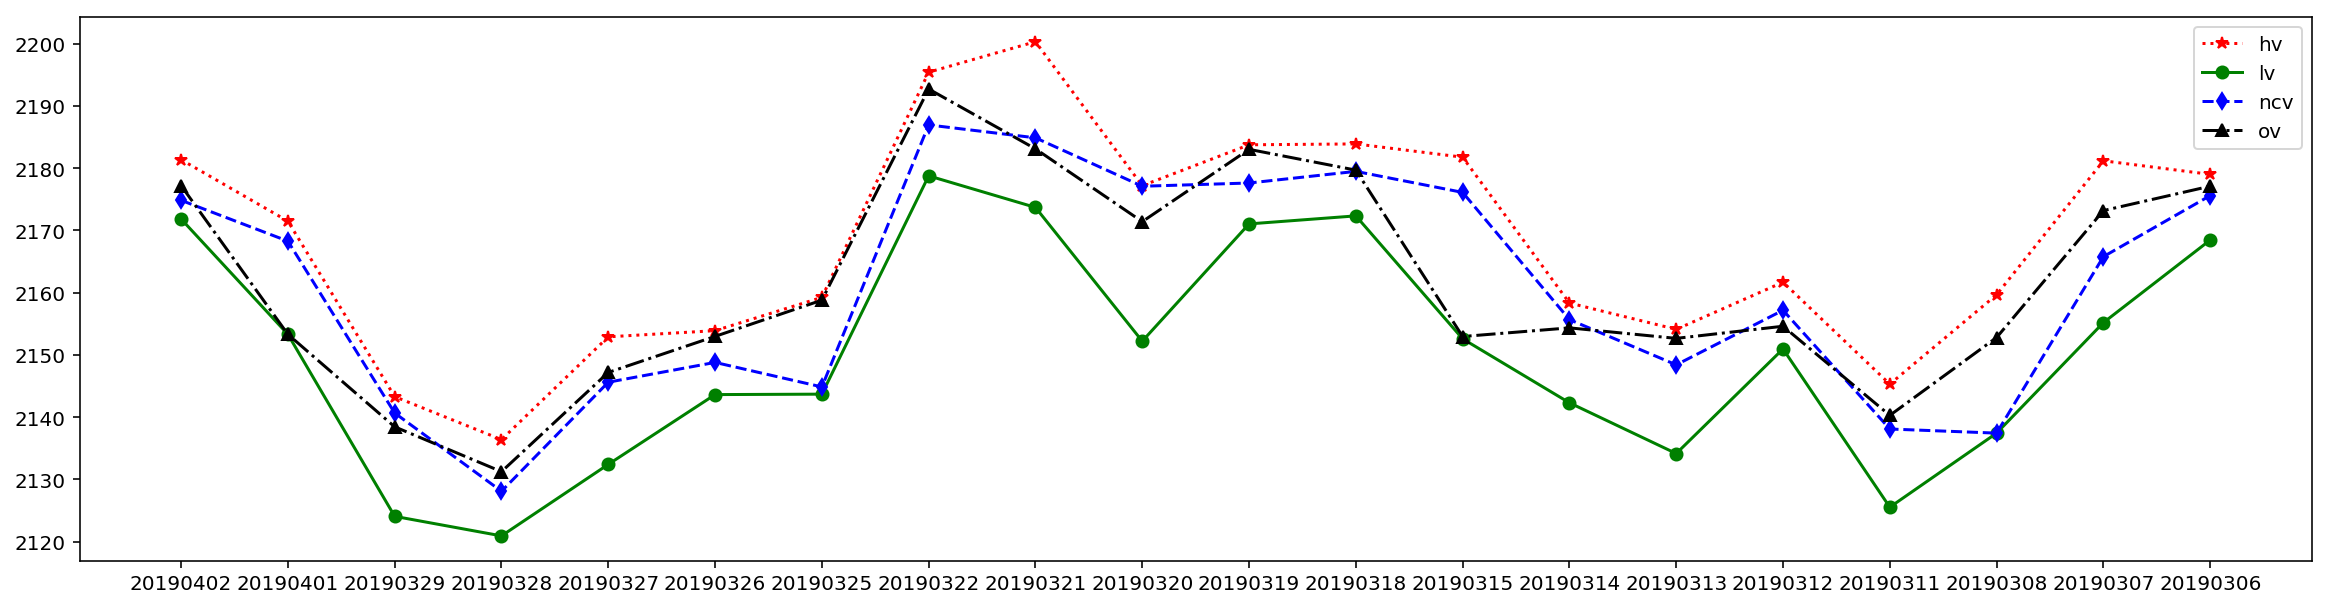

In [6]:
# 그려질 그래프의 크기를 설정
plt.figure(figsize=(20, 5))

# 그래프 데이터를 적용
plt.plot(kospi["날짜"], kospi["고가"], 'r*:', label="hv")
plt.plot(kospi["날짜"], kospi["저가"], 'go-', label="lv")
plt.plot(kospi["날짜"], kospi["종가"], 'bd--', label="ncv")
plt.plot(kospi["날짜"], kospi["시가"], 'k^-.', label="ov")

# 범례 설정
plt.legend(loc=0)

# 그래프를 그려줌
plt.show()

class로 만들기

In [7]:
class Kospi:

    def __init__(self, page_size=20, page=1):
        self.df = None
        self.page_size = page_size
        self.page = page

    def __make_url(self):
        # 객체의 page_size와 page변수를 이용하여 url을 만들어서 리턴
        return "https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?\
                code=KOSPI&pageSize={}&page={}".format(self.page_size, self.page)

    def crawling(self, page_size=20, page=1):

        self.page_size, self.page = page_size, page  # 페이지 사이즈와 페이지 설정
        url = self.__make_url()  # url 만들기
        response = requests.get(url)  # url에 해당하는 문자열 가져오기

        # json 객체 형태로 파싱(문자열을 dictionary 데이터 타입으로 변경)
        kospi_json = response.json()

        # result와 siseList에 해당되는 데이터를 선택
        kospi = kospi_json["result"]["siseList"]

        # json(dictionary)데이터 타입을 pandas의 데이터 프레임으로 변경
        self.df = pd.io.json.json_normalize(kospi)

        print("Crawling Done!")

In [8]:
class Kospi2(Kospi):
    
    def draw(self, axis=(20, 5)):

        # 그려질 그래프의 크기를 설정
        plt.figure(figsize=(20, 5))

        # 그래프 데이터를 적용
        plt.plot(kospi["날짜"], kospi["고가"], 'r*:', label="hv")
        plt.plot(kospi["날짜"], kospi["저가"], 'go-', label="lv")
        plt.plot(kospi["날짜"], kospi["종가"], 'bd--', label="ncv")
        plt.plot(kospi["날짜"], kospi["시가"], 'k^-.', label="ov")

        # 범례 설정
        plt.legend(loc=0)

        # 그래프를 그려줌
        plt.show()

객체 만들기

In [9]:
KOSPI = Kospi()

크롤링

In [10]:
KOSPI.crawling(10, 2)

Crawling Done!


데이터 확인

In [11]:
KOSPI.df.tail()

cd    cr     cv        dt       hv       lv      ncv       ov
5  KOSPI  0.89  19.08  20190312  2161.69  2150.96  2157.18  2154.61
6  KOSPI  0.03   0.66  20190311  2145.31  2125.54  2138.10  2140.29
7  KOSPI -1.31 -28.35  20190308  2159.67  2137.44  2137.44  2152.80
8  KOSPI -0.45  -9.81  20190307  2181.19  2155.19  2165.79  2173.19
9  KOSPI -0.17  -3.63  20190306  2179.01  2168.46  2175.60  2177.11

그래프 그리기

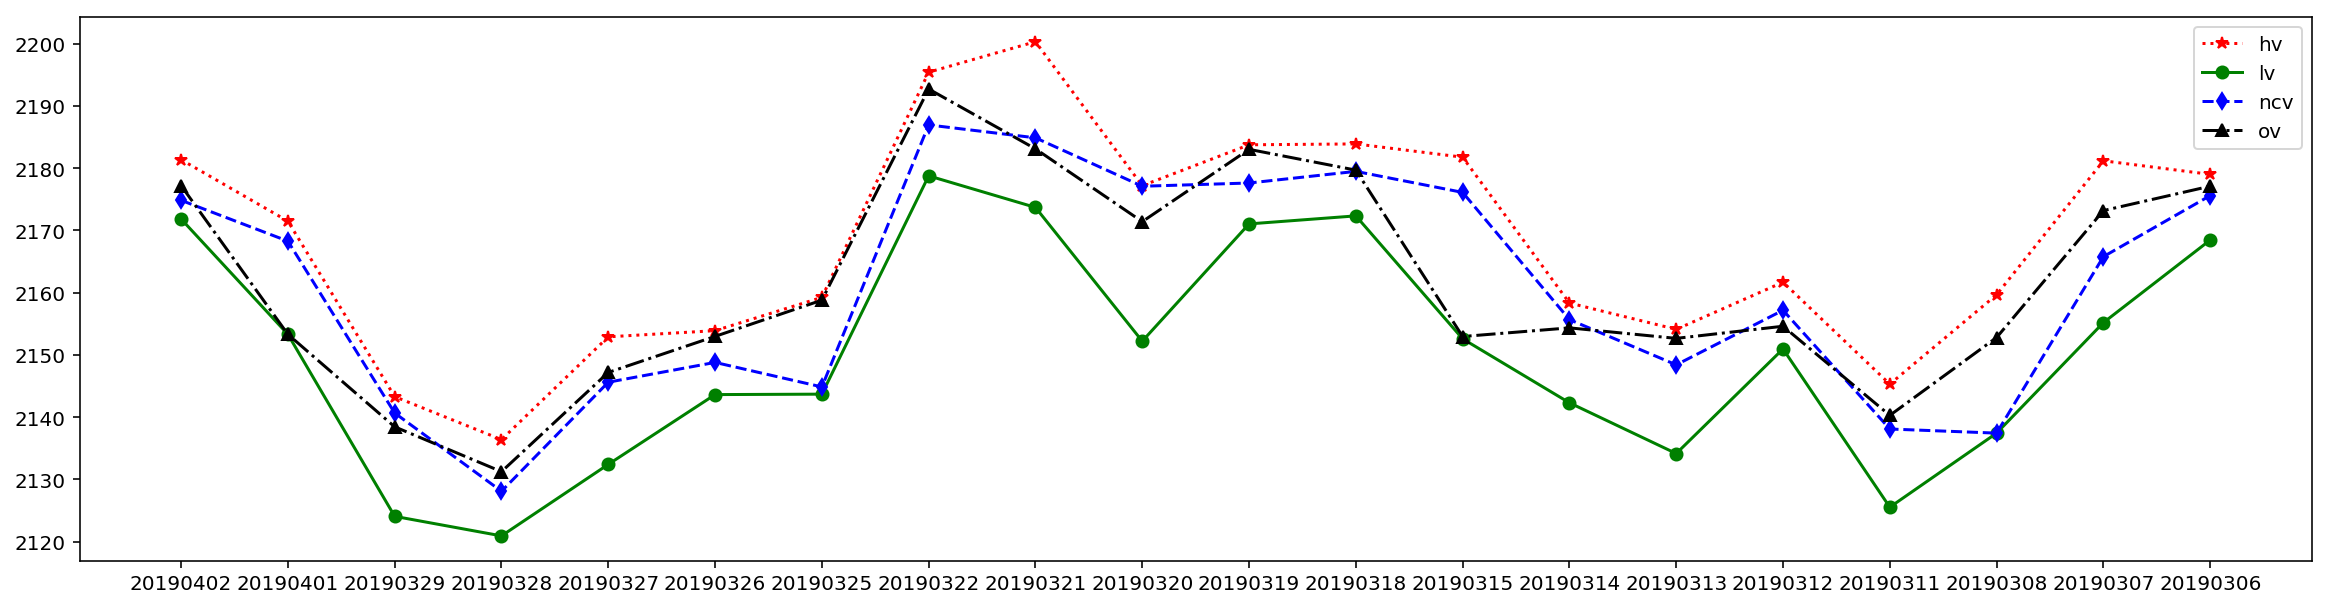

In [12]:
KOSPI2 = Kospi2()
KOSPI2.draw()

### Dark Sky API
- API를 서비스하는 업체의 API를 사용하는 방법에 대해서 학습
- 위도와 경도를 입력하면 날씨 요약 정보를 보내주는 API
- https://darksky.net/dev
- 회원 가입후 로그인
- https://darksky.net/dev/account
- 토큰값을 획득 : be47f833ca44e524972bd9231cae1c5b (본인의 토큰값을 사용)

토큰 값을 변수로 설정
- 본인의 토큰값을 사용

In [13]:
TOKEN = "be47f833ca44e524972bd9231cae1c5b"

위도와 경도를 입력하면 해당 지역의 날씨 요약 정보를 출력 하는 함수 만들기

In [14]:
def forecast(lat, lng):

    # 토큰 위도 경도 데이터가 들어간
    url = "https://api.darksky.net/forecast/{}/{},{}".format(TOKEN, lat, lng)

    # 만들어진 URL을 출력
    print(url)

    # url값으로 request 요청
    response = requests.get(url)

    # 문자열 데이터를 json object(dictionary) 객체로 파싱
    weather_obj = response.json()

    # timezone에 해당하는 지역이름과 시간에 대한 날찌 요약정보를 리턴
    return weather_obj["timezone"], weather_obj["hourly"]["summary"]

In [15]:
lat = 37.8267
lng = -122.4233
forecast(lat, lng)

https://api.darksky.net/forecast/be47f833ca44e524972bd9231cae1c5b/37.8267,-122.4233


('America/Los_Angeles', 'Mostly cloudy throughout the day.')

In [16]:
lat = 37.5665
lng = 126.9780
forecast(lat, lng)

https://api.darksky.net/forecast/be47f833ca44e524972bd9231cae1c5b/37.5665,126.978


('Asia/Seoul', 'Partly cloudy this evening.')

### 2. BS4를 이용해서 파싱
- html 파일을 문자열로 받고, css selector를 이용해서 원하는 문자열 데이터를 받아오는 방법
- 네이버 실시간 검색어 랭킹 데이터 크롤링
- 다음 실시간 검색어 랭킹 데이터 크롤링

#### 네이버 실시간 검색어
- requests를 이용하여 html 문자열 데이터를 가져옴
- bs4 패키지의 BeautifulSoup 함수를 이용하여 css selector를 사용할수 있는 객체로 Parsing
- 원하는 데이터를 css selector를 이용하여 가져옴

In [17]:
def naver_keywords():

    # 데이터 프레임 만들기
    df = pd.DataFrame(columns=["rank", "keyword"])

    # naver 메인페이지 URL을 requests로 요청
    response = requests.get("https://www.naver.com/")

    # 받아온 데이터를 html 객체 형태로 파싱
    dom = BeautifulSoup(response.content, "html.parser")

    # 키워드 순위에 해당하는 HTML 엘리먼트 객체 가져오기
    # select - 여러개의 엘리먼트를 선택 - 결과가 리스트
    # select_one - 하나의 엘리먼트를 선택 - 결과가 하나의 객체
    keywords = dom.select(".ah_roll_area > .ah_l > .ah_item")

    # 가져온 여러개의 keywords 객체들을 데이터 프레임에 넣어줌
    for keyword in keywords:
        df.loc[len(df)] = {
            "rank": keyword.select_one('.ah_r').text,
            "keyword": keyword.select_one('.ah_k').text,
        }
    return df

함수를 실행하여 크롤링 결과 확인

In [18]:
naver_keywords().head()

rank   keyword
0    1     국민여러분
1    2       황하나
2    3  위메프 낱말퍼즐
3    4      관혼상제
4    5       이유영

5초 간격으로 3번 크롤링하고 csv파일로 저장하기

In [19]:
for idx in range(3):
    naver_keywords_df = naver_keywords()
    naver_keywords_df.to_csv("naver_" + str(idx) + ".csv")
    time.sleep(5)

#### Daum 실시간 검색어
- Dom 구조 파악
- `https://www.daum.net/` 페이지 requests 모듈로 크롤링
- BeautifulSoup을 이용하여 dom 객체로 파싱
- css selector를 이용하여 검색어 데이터 가져오기
- 데이터 프레임으로 만들기

In [20]:
def daum_keywords():
    df = pd.DataFrame(columns=["rank", "keyword"])
    response = requests.get("https://www.daum.net/")
    dom = BeautifulSoup(response.content, "html.parser")
    keywords = dom.select(".realtime_part > .list_hotissue.issue_row > li")
    df["keyword"] = [keyword.select_one(
        '.link_issue').text for keyword in keywords]
    df["rank"] = [keyword.select_one('.ir_wa').text[:-1]
                  for keyword in keywords]
    return df


daum_keywords_df = daum_keywords()
daum_keywords_df

rank keyword
0    1     황하나
1    2  국민 여러분
2    3    강다니엘
3    4     나영석
4    5     방정오
5    6     이하늬
6    7    경남fc
7    8    디스패치
8    9    남양유업
9   10     최시원

- naver_df와 daum_df의 중복 키워드 찾기

In [21]:
set(naver_keywords_df["keyword"]) & set(daum_keywords_df["keyword"])

{'나영석', '남양유업', '디스패치', '방정오', '최시원', '황하나'}

### 3. 직방 사이트 API를 이용하여 크롤링
- 크롤링한 데이터를 이용해서 크롤링 하는 방법을 실습
- robots.txt : 사이트의 크롤링 정책에 대해서 알려주는페이지
- 직방 사이트에서 동 데이터를 입력하면 부동산 물건을 데이터 프레임으로 가져오기
    - zigbang("망원동") -> 망원동 물건이 데이터 프레임
    - 직방 사이트 : https://www.zigbang.com/

- 크롤링 절차
    - 지역정보
        - 동을 입력하면 위도와 경도 데이터를 가져옴
        - path : all
        - 망원동 -> 위도, 경도
    - 아이템 아이디 
        - 위도, 경도를 입력하면 부동산 물건에 대한 아이템 아이디를 가져옴
        - path : items2
        - 위도, 경도 -> 아이템 아이디
    - 물건 리스트
        - 부동산 물건에 대한 아이템 아이디를 입력하면 물건 리스트를 가져옴
        - path : items
        - 아이템 아이디 -> 물건 리스트

#### 지역정보
- 동 -> 위도와 경도

In [22]:
def get_addr_info(keyword="망원동"):

    # url을 만들고 requests를 이용하여 response 객체를 받아옴
    url = "https://apis.zigbang.com/search/all?q={}&type=oneroom".format(
        keyword)
    response = requests.get(url)

    # 받아온 문자열 데이터를 json 객체로 파싱
    json_obj = response.json()

    # 위도와 경도값을 tuple로 리턴
    return json_obj["items"][0]["lat"], json_obj["items"][0]["lng"]


# test code
lat, lng = get_addr_info("방배동")
lat, lng

(37.48341369628906, 126.9944839477539)

#### 아이디 리스트
- 위도와 경도 -> 아이디 리스트
- 위도 경도 0.01 차이로 검색

In [23]:
# urlencode : dictionary 데이터를 url 쿼리로 변경해주는 함수
from urllib.parse import urlencode

In [24]:
def get_ids(lat, lng):

    # 위도와 경도 값을 받아서 URL을 만들어줌
    url = "https://api.zigbang.com/v3/items2?\
            lat_south={}&lat_north={}&lng_west={}&lng_east={}\
            &room=[01,02,03,04,05]".format(lat - 0.01, lat + 0.01, lng - 0.01, lng + 0.01)

    # 위도와 경도의 0.01 차이의 데이터 딕셔너리로 만듦
    params = {
        "lat_south": lat - 0.01,
        "lat_north": lat + 0.01,
        "lng_west": lng - 0.01,
        "lng_east": lng + 0.01,
        "room": "[01,02,03,04,05]",
    }

    # 딕셔너리 데이터를 URL 쿼리 형태로 파싱
    params_str = urlencode(params)

    # 파싱된 쿼리를 URL에 추가
    url = "https://api.zigbang.com/v3/items2?" + params_str
    print(url)

    # 위에서 만들어진 url로 requests 하여 response 객체를 받음
    response = requests.get(url)

    # json으로 파싱
    json_obj = response.json()

    # json으로 객체에서 아이템 리스트를 선택
    items = json_obj["list_items"]

    # 아이디 값을 리스트로 리턴
    return [item["simple_item"]["item_id"] for item in items]

In [25]:
# test code
ids = get_ids(lat, lng)
len(ids), ids[:5]

https://api.zigbang.com/v3/items2?lat_south=37.473413696289064&lat_north=37.49341369628906&lng_west=126.9844839477539&lng_east=127.00448394775391&room=%5B01%2C02%2C03%2C04%2C05%5D


(257, [15444356, 15620845, 15642857, 15623422, 15617742])

#### 물건 리스트
- 아이디 리스트 -> 부동산 물건 데이터 프레임

In [26]:
# json 포멧의 데이터를 데이터프레임으로 바로 만들어주는 함수
from pandas.io.json import json_normalize

In [27]:
def get_items(ids):

    # ids(아이디 리스트)로 url을 만들어줌
    url = "https://api.zigbang.com/v3/items?detail=true&item_ids={}"\
        .format(str(ids).replace(" ", ""))

    # requests를 이용하여 response 객체를 받음
    response = requests.get(url)

    # json 객체로 파싱
    json_obj = response.json()

    # 필요한 아이템 데이터만 필터링
    items = json_obj["items"]
    datas = [item["item"] for item in items]

    # json 객체(딕셔너리 타입) 데이터를 데이터 프레임으로 변경
    result_df = json_normalize(datas)

    # 필요한 컬럼만 필터링
    filter_colums = ["_floor", "address1", "address2",
                     "user_email", "rent", "size", "deposit", "options"]
    return result_df[filter_colums]

In [28]:
# test code
result_df = get_items(ids[:5])
result_df

_floor     address1 address2           user_email  rent  size  deposit  \
0     3층  서울시 서초구 방배동   853-16     wjsphs@naver.com    54     7     2000   
1     1층  서울시 서초구 방배동   877-12   hnahyeon@naver.com    43     5      500   
2     2층  서울시 서초구 방배동   890-29      memul@naver.com     0    15    26000   
3     3층  서울시 서초구 방배동   929-30  jaewoon82@naver.com    55     6     1000   
4     3층  서울시 서초구 방배동    824-3  nanume114@naver.com    65     8     1000   

                            options  
0  에어컨,냉장고,세탁기,인덕션,책상,책장,옷장,신발장,싱크대  
1        에어컨,냉장고,세탁기,인덕션,옷장,신발장,싱크대  
2             에어컨,세탁기,가스레인지,신발장,싱크대  
3        에어컨,냉장고,세탁기,인덕션,옷장,신발장,싱크대  
4        에어컨,냉장고,세탁기,인덕션,옷장,신발장,싱크대

모든 함수를 하나의 함수로 통합

In [29]:
def main(addr="망원동"):

    # 동 -> 위도, 경도
    lat, lng = get_addr_info(addr)

    # 위도 경도 -> 아이디 리스트
    ids = get_ids(lat, lng)

    # 아이디 리스트 -> 부동산 물건 데이터 프레임
    return get_items(ids)

In [30]:
df = main("합정동")
df.tail()

https://api.zigbang.com/v3/items2?lat_south=36.976083984375&lat_north=36.996083984375&lng_west=127.08906005859376&lng_east=127.10906005859377&room=%5B01%2C02%2C03%2C04%2C05%5D


_floor     address1 address2            user_email  rent  size  deposit  \
199      2층  경기도 평택시 합정동    922-4   yukim7776@naver.com    52  18.0      500   
200      2층  경기도 평택시 합정동   899-12   qkfms0200@naver.com    50  20.0      500   
201  고층/16층  경기도 평택시 평택동    293-4  0195835774@naver.com    30   7.0     1000   
202      4층  경기도 평택시 합정동   741-20     ykk1325@naver.com    65  25.0     1000   
203  고층/18층  경기도 평택시 평택동    294-3  dhrkfl0708@naver.com    45   8.0      300   

                                    options  
199                                       -  
200                                       -  
201        에어컨,냉장고,세탁기,인덕션,책상,책장,옷장,신발장,싱크대  
202                                       -  
203  에어컨,냉장고,세탁기,인덕션,전자레인지,책상,책장,옷장,신발장,싱크대